# Image Compression 


In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from ProcessData import *
import cvxpy as cp
from Calculation import *
from BIHT import *
from Visualization import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import ecos
import random
import pickle

In [2]:
# 导入数据
train_file = 'mnist_train.csv'
test_file = 'mnist_test.csv'

with open(train_file, 'r') as f:
    train_data_reader = csv.reader(f)
    train_data = list(train_data_reader)
    train_data_array = np.array(train_data, dtype=float)  # 转换为浮点数类型
    
with open(test_file, 'r') as f:
    test_data_reader = csv.reader(f)
    test_data = list(test_data_reader)
    test_data_array = np.array(test_data, dtype=float)  # 转换为浮点数类型

print(f'Size of Training Set：{np.shape(train_data_array)}')
print(f'Size of Testing Set: {np.shape(test_data_array)}')

# 分离标签和特征, 我们不需要标签
y_train = train_data_array[:, 0]  # 第一列是标签
X_train = train_data_array[:, 1:]  # 剩余的列是特征

y_test = test_data_array[:, 0]  # 第一列是标签
X_test = test_data_array[:, 1:]  # 剩余的列是特征

X_train_DL = X_train
X_test_DL = X_test
X_train_DL = X_train / 255 
X_test_DL = X_test / 255
# 对原始图像归一化，见BIHT论文
for i in range(X_train.shape[0]):
    norm = np.linalg.norm(X_train[i])
    if norm > 0:
        X_train[i] = X_train[i] / norm

for i in range(X_test.shape[0]):
    norm = np.linalg.norm(X_test[i])
    if norm > 0:
        X_test[i] = X_test[i] / norm

print(f'训练标签形状: {y_train.shape}')
print(f'训练特征形状: {X_train.shape}')
print(f'测试标签形状: {y_test.shape}')
print(f'测试特征形状: {X_test.shape}')


Size of Training Set：(60000, 785)
Size of Testing Set: (10000, 785)
训练标签形状: (60000,)
训练特征形状: (60000, 784)
测试标签形状: (10000,)
测试特征形状: (10000, 784)


# 1.0 Take look at the images and sparsity levels

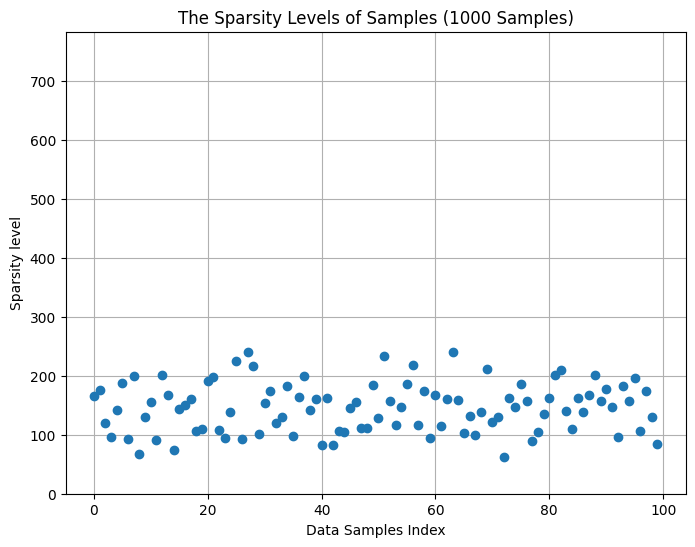

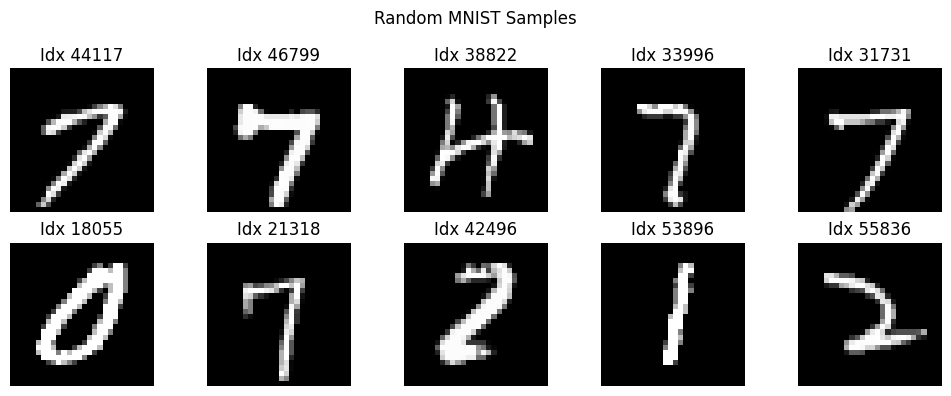

In [3]:
sparsity_list = []
for i in range(100):
    sparsity = Calculate_Sparse(X_train[i])
    sparsity_list.append(sparsity)

plt.figure(figsize=(8, 6))
plt.plot(sparsity_list, 'o')
plt.ylabel('Sparsity level')
plt.xlabel('Data Samples Index')
plt.ylim([0, 784])
plt.grid(True)
plt.title('The Sparsity Levels of Samples (1000 Samples)')
plt.show()

random_indices = random.sample(range(len(X_train)), 10)
plt.figure(figsize=(10, 4))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx].reshape([28, 28]), cmap='gray')
    plt.axis('off')
    plt.title(f'Idx {idx}')
plt.suptitle('Random MNIST Samples')
plt.tight_layout()
plt.show()

## 1.1 Generate Matrix A

In [4]:

Matrix_A_25_784 = Generate_Standard_Matrix_A(25, 784)    # 调用, 产生25x25的随机高斯矩阵A，其中每一列已经单位l2norm了
Matrix_A_100_784 = Generate_Standard_Matrix_A(100, 784)
Matrix_A_200_784 = Generate_Standard_Matrix_A(200, 784)
Matrix_A_500_784 = Generate_Standard_Matrix_A(500, 784)

## 1.2 Apply Sign Function

In [5]:
# 对Ax施加sign函数，获得全1或者-1的值
x_true = X_train[100]
y_25_784 = np.sign(Matrix_A_25_784 @ x_true)     # (25, )
y_100_784 = np.sign(Matrix_A_100_784 @ x_true)
y_200_784 = np.sign(Matrix_A_200_784 @ x_true)
y_500_784 = np.sign(Matrix_A_500_784 @ x_true)



# 1.3 See the recovery of the selected image
Try BIHT

0.7934434518030411
[-0.          0.         -0.          0.          0.          0.
  0.         -0.          0.         -0.         -0.         -0.10616945
 -0.         -0.         -0.         -0.          0.          0.
  0.          0.          0.         -0.          0.          0.
  0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.09987477  0.         -0.          0.         -0.10523929
 -0.         -0.09027951  0.          0.          0.         -0.
 -0.          0.         -0.          0.07870134  0.          0.
  0.          0.          0.         -0.          0.         -0.
 -0.          0.          0.          0.          0.         -0.00414077
 -0.          0.         -0.          0.          0.          0.
  0.          0.         -0.         -0.         -0.         -0.
  0.         -0.         -0.          0.         -0.          0.
  0.          0.01990419 -0.         -0.         -0.          0.
  0.         -0.          0.         -0.       

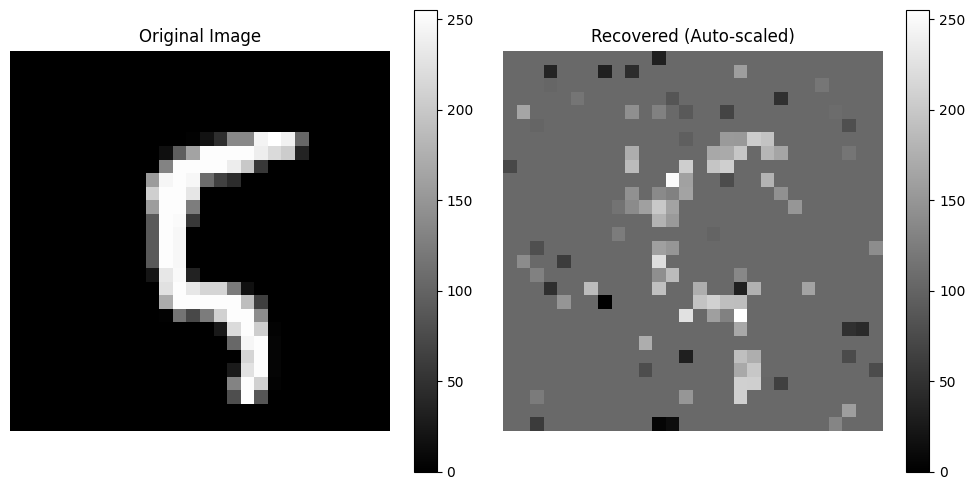

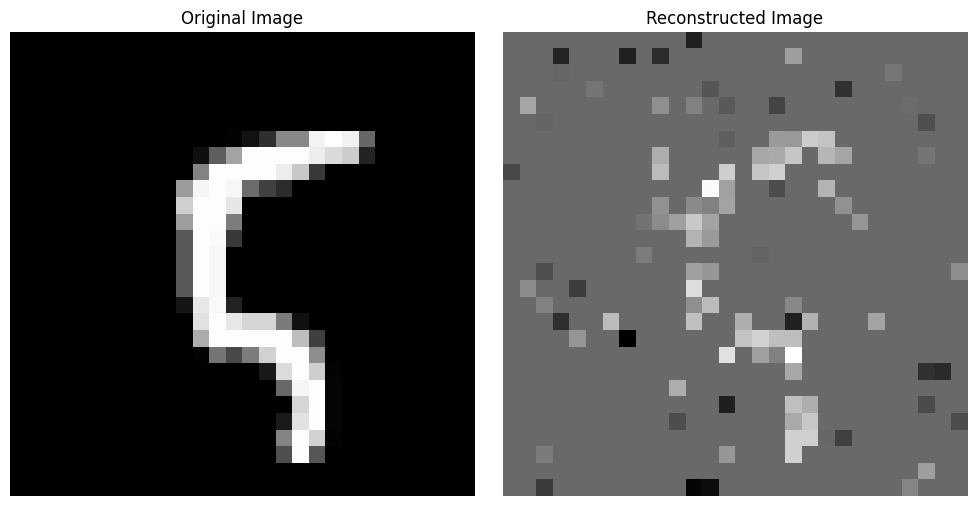

In [6]:

x_recovered = biht(Matrix_A_500_784, y_500_784, Calculate_Sparse(x_true), max_iter=20000)
mse, nmse = compute_metrics(x_true, x_recovered)
print(nmse)
# print(mse)
# print(nmse)
print(x_recovered)
# print(x_true)

display_recovered_image_color(x_recovered, x_true)
display_recovered_image(x_recovered, x_true)


# 2.1 Generate A Matrix


In [16]:
measurements = [25, 100, 200, 500, 800, 1000, 1500, 2000]


A_dict = {
    '25': Generate_Standard_Matrix_A(25, 784),
    '100': Generate_Standard_Matrix_A(100, 784),
    '200': Generate_Standard_Matrix_A(200, 784),
    '500': Generate_Standard_Matrix_A(500, 784),
    '800': Generate_Standard_Matrix_A(800, 784),
    '1000': Generate_Standard_Matrix_A(1000, 784),
    '1500': Generate_Standard_Matrix_A(1500, 784),
    '2000': Generate_Standard_Matrix_A(2000, 784)
}

# For test data
y_test_dict = {
    '25': np.sign(A_dict['25'] @ X_test.T),
    '100': np.sign(A_dict['100'] @ X_test.T),
    '200': np.sign(A_dict['200'] @ X_test.T),
    '500': np.sign(A_dict['500'] @ X_test.T),
    '800': np.sign(A_dict['800'] @ X_test.T),
    '1000': np.sign(A_dict['1000'] @ X_test.T),
    '1500': np.sign(A_dict['1500'] @ X_test.T),
    '2000': np.sign(A_dict['2000'] @ X_test.T)
}

# For training data
y_train_dict = {
    '25': np.sign(A_dict['25'] @ X_train.T),
    '100': np.sign(A_dict['100'] @ X_train.T),
    '200': np.sign(A_dict['200'] @ X_train.T),
    '500': np.sign(A_dict['500'] @ X_train.T),
    '800': np.sign(A_dict['800'] @ X_train.T),
    '1000': np.sign(A_dict['1000'] @ X_train.T),
    '1500': np.sign(A_dict['1500'] @ X_train.T),
    '2000': np.sign(A_dict['2000'] @ X_train.T)
}

data_to_save = {
    'A_dict': A_dict,
    'y_test_dict': y_test_dict,
    'y_train_dict': y_train_dict
}

with open('A_dict.pkl', 'wb') as f:
    pickle.dump(A_dict, f)


# 2.1 Try BIHT

Current Measurement: 25
Current Measurement: 100
Current Measurement: 200
Current Measurement: 500
Current Measurement: 800
Current Measurement: 1000
Current Measurement: 1500
Current Measurement: 2000


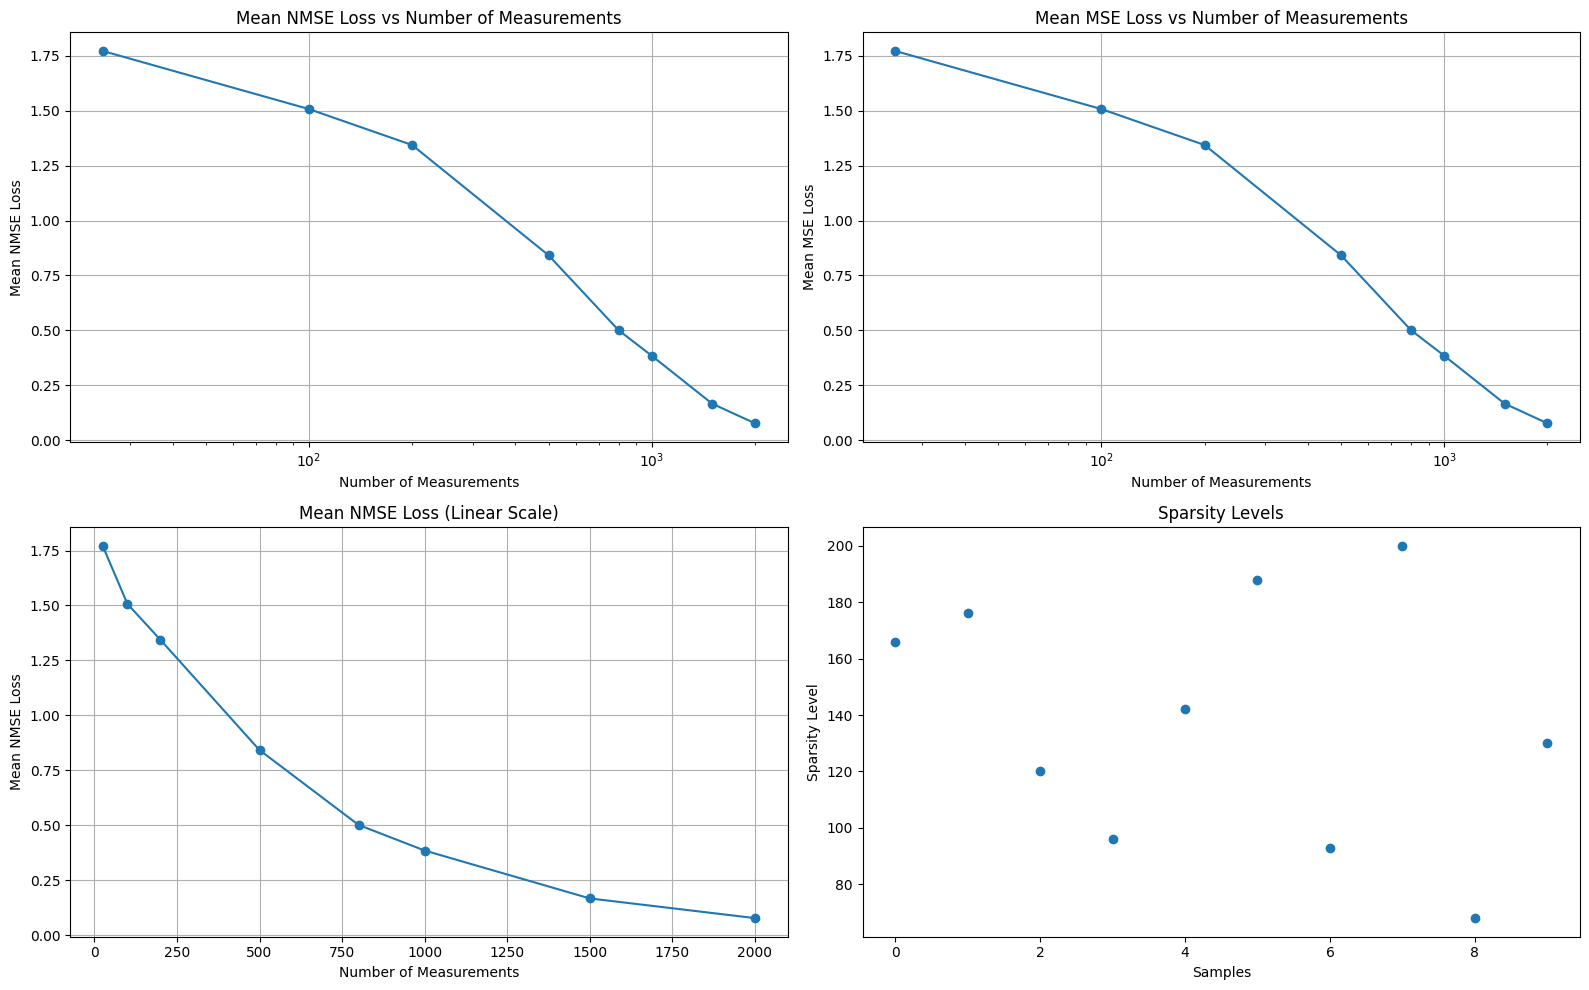

Measurements: [25, 100, 200, 500, 800, 1000, 1500, 2000]
Mean NMSE: [1.7716189576343169, 1.5070951054799198, 1.3434755573326145, 0.8418551126535349, 0.5012003220316403, 0.38480540327051604, 0.16692203461246266, 0.07732338458511807]
Mean MSE: [1.7716189576343164, 1.5070951054799193, 1.3434755573326145, 0.8418551126535349, 0.5012003220316402, 0.384805403270516, 0.16692203461246263, 0.07732338458511806]


In [17]:

with open('A_dict.pkl', 'rb') as f:
    A_dict = pickle.load(f)

def run_biht_without_tau(X_train, measurements):
    nmse_lists = [[] for _ in measurements]
    mse_lists = [[] for _ in measurements]
    sparsity_list = []

    for m_idx, m in enumerate(measurements):
        m_str = str(m)
        print(f'Current Measurement: {m}')
        matrix = A_dict[m_str]

        for i in range(10):
            x_true = X_train[i]
            sparsity = Calculate_Sparse(x_true)
            
            if m_idx == 0:  # 只在第一个测量数时记录稀疏性
                sparsity_list.append(sparsity)
            
            y = np.sign(matrix @ x_true)
            x_recovered = biht(matrix, y, sparsity, max_iter=1000)
            mse, nmse = compute_metrics(x_true, x_recovered)
            
            nmse_lists[m_idx].append(nmse)
            mse_lists[m_idx].append(mse)

    return nmse_lists, mse_lists, sparsity_list 

# 运行实验
nmse_lists, mse_lists, sparsity_list = run_biht_without_tau(X_train, measurements)

# 计算均值
mean_nmse_biht = [np.mean(nmse_list) for nmse_list in nmse_lists]
mean_mse = [np.mean(mse_list) for mse_list in mse_lists]

# 画图
plt.figure(figsize=(16, 10))

# NMSE Plot
plt.subplot(2, 2, 1)
plt.plot(measurements, mean_nmse_biht, 'o-')
plt.xlabel("Number of Measurements")
plt.ylabel("Mean NMSE Loss")
plt.title("Mean NMSE Loss vs Number of Measurements")
plt.xscale('log')
plt.grid(True)

# MSE Plot
plt.subplot(2, 2, 2)
plt.plot(measurements, mean_mse, 'o-')
plt.xlabel("Number of Measurements")
plt.ylabel("Mean MSE Loss")
plt.title("Mean MSE Loss vs Number of Measurements")
plt.xscale('log')
plt.grid(True)

# NMSE Detailed View
plt.subplot(2, 2, 3)
plt.plot(measurements, mean_nmse_biht, 'o-')
plt.xlabel("Number of Measurements")
plt.ylabel("Mean NMSE Loss")
plt.title("Mean NMSE Loss (Linear Scale)")
plt.grid(True)

# Sparsity Distribution
plt.subplot(2, 2, 4)
plt.plot(range(len(sparsity_list)), sparsity_list, 'o')
plt.title("Sparsity Levels")
plt.xlabel("Samples")
plt.ylabel("Sparsity Level")

plt.tight_layout()
plt.show()

print("Measurements:", measurements)
print("Mean NMSE:", mean_nmse_biht)
print("Mean MSE:", mean_mse)

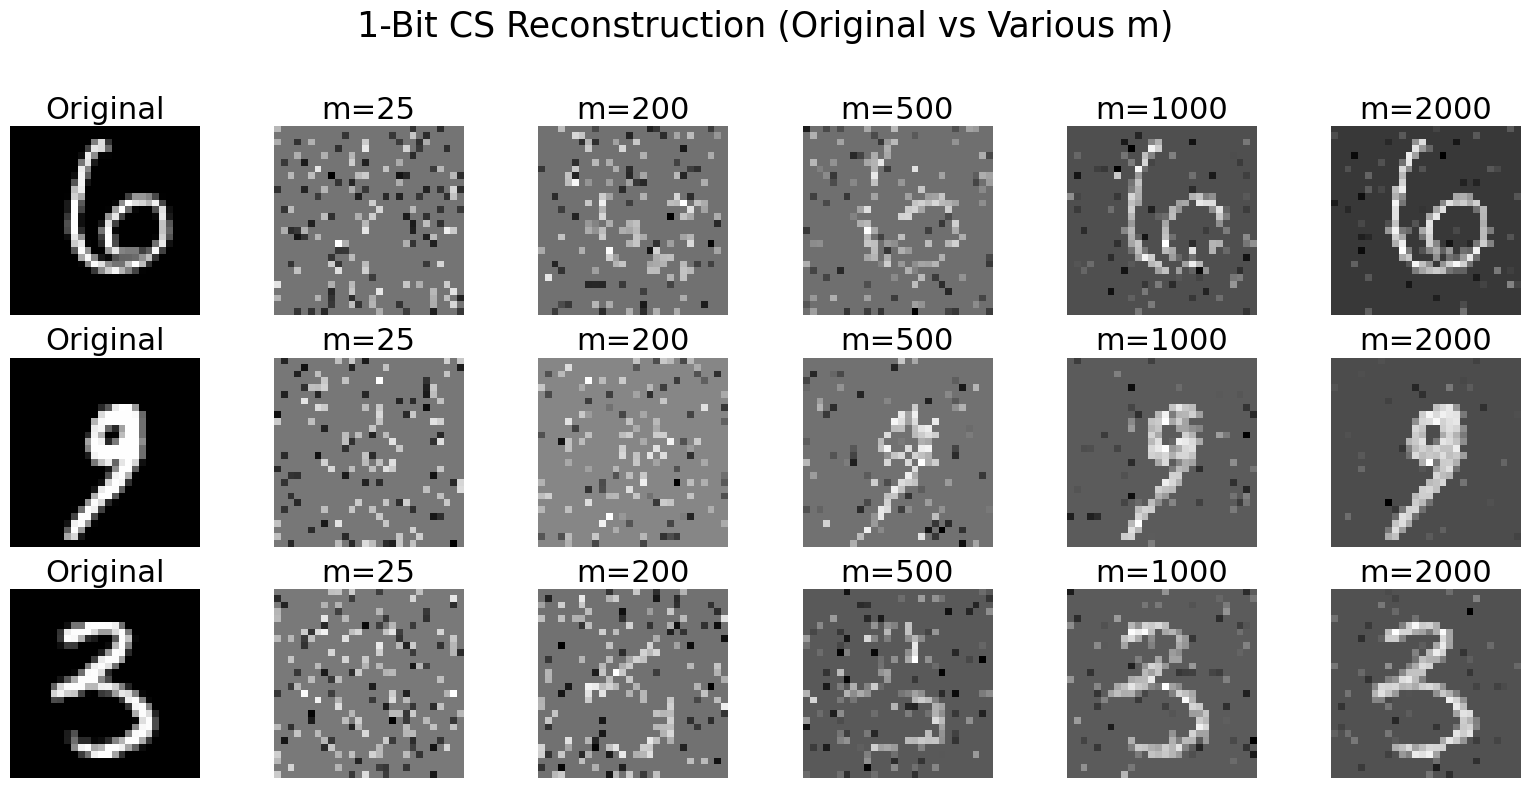

In [22]:
# Show the images of BIHT

with open('A_dict.pkl', 'rb') as f:
    A_dict = pickle.load(f)

measurements_biht_show = [25, 200, 500, 1000, 2000]
sample_indices = [100, 1000, 5000]

def run_biht_no_norm(X_test, indices, measurements):
    results = []

    for idx in indices:
        x_true = X_test[idx]  # 不归一化
        recon_list = []

        for m in measurements_biht_show:
            A = A_dict[str(m)]
            y = np.sign(A @ x_true)
            sparsity = Calculate_Sparse(x_true)
            x_recon = biht(A, y, sparsity, max_iter=1000)
            recon_list.append(x_recon)

        results.append((x_true, recon_list))

    return results


recon_results = run_biht_no_norm(X_test, sample_indices, measurements_biht_show)
fig, axes = plt.subplots(len(sample_indices), len(measurements_biht_show)+1, figsize=(16, 8))

for row, (x_true, x_recons) in enumerate(recon_results):
    axes[row, 0].imshow(x_true.reshape(28, 28), cmap='gray')
    axes[row, 0].set_title("Original", fontsize=22)
    axes[row, 0].axis('off')

    for col, x_recon in enumerate(x_recons):
        axes[row, col+1].imshow(x_recon.reshape(28, 28), cmap='gray')
        axes[row, col+1].set_title(f"m={measurements_biht_show[col]}", fontsize=22)
        axes[row, col+1].axis('off')

plt.suptitle("1-Bit CS Reconstruction (Original vs Various m)", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# 2.2 Deep Learning Methods: MLP

使用保存的矩阵: 维度 25
Training model with input_dim = 25...
Device: cuda


c:\Data\Software\anaconda3\envs\bayesian_project\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], LR: 0.001000, Train Loss: 0.028402, Test Loss: 0.001081, MSE: 8470.829502, NMSE: 0.949375
Epoch [2/50], LR: 0.001000, Train Loss: 0.001734, Test Loss: 0.000980, MSE: 7684.545099, NMSE: 0.890348
Epoch [3/50], LR: 0.001000, Train Loss: 0.001330, Test Loss: 0.000968, MSE: 7588.908536, NMSE: 0.866990
Epoch [4/50], LR: 0.001000, Train Loss: 0.001135, Test Loss: 0.000852, MSE: 6679.477936, NMSE: 0.754511
Epoch [5/50], LR: 0.001000, Train Loss: 0.001034, Test Loss: 0.000789, MSE: 6187.314559, NMSE: 0.719628
Epoch [6/50], LR: 0.001000, Train Loss: 0.000917, Test Loss: 0.000691, MSE: 5418.268204, NMSE: 0.633756
Epoch [7/50], LR: 0.001000, Train Loss: 0.000825, Test Loss: 0.000726, MSE: 5689.696456, NMSE: 0.649218
Epoch [8/50], LR: 0.001000, Train Loss: 0.000649, Test Loss: 0.000551, MSE: 4316.052519, NMSE: 0.492255
Epoch [9/50], LR: 0.001000, Train Loss: 0.000608, Test Loss: 0.000527, MSE: 4130.830569, NMSE: 0.467231
Epoch [10/50], LR: 0.001000, Train Loss: 0.000590, Test Loss: 0.

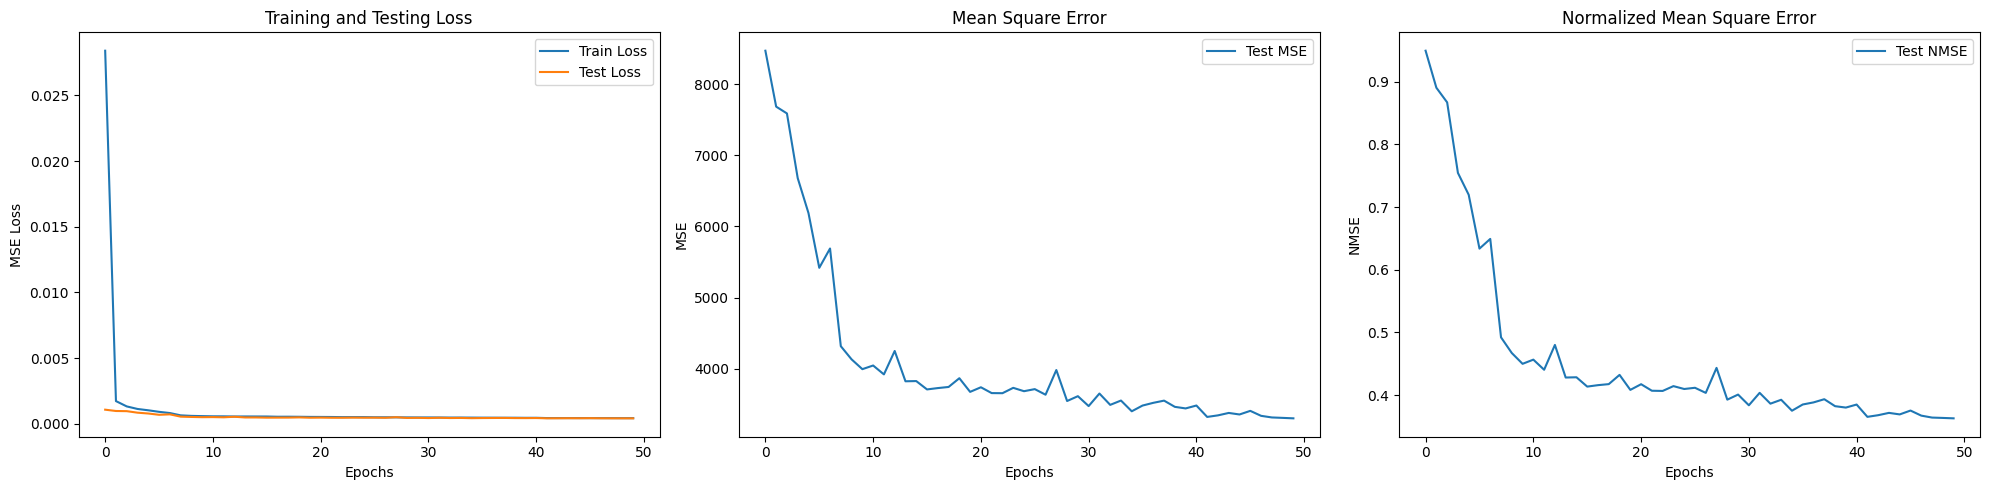

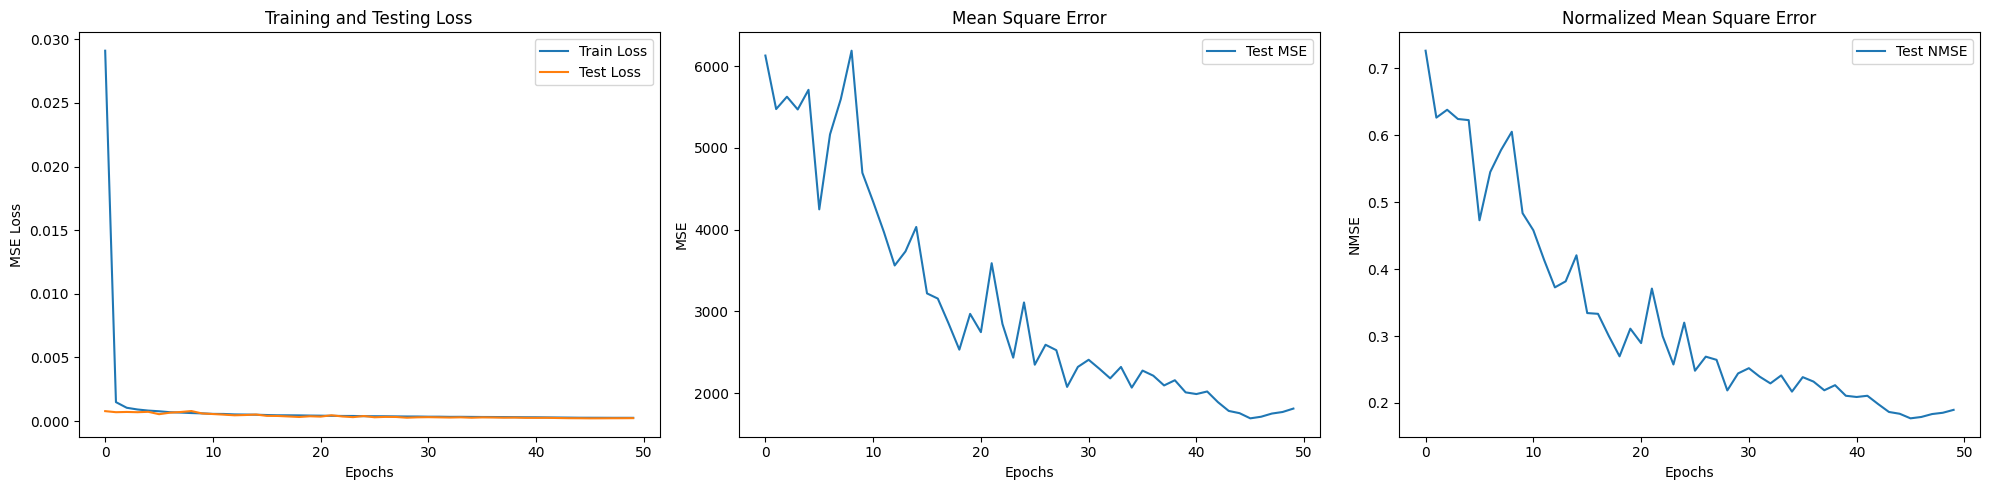

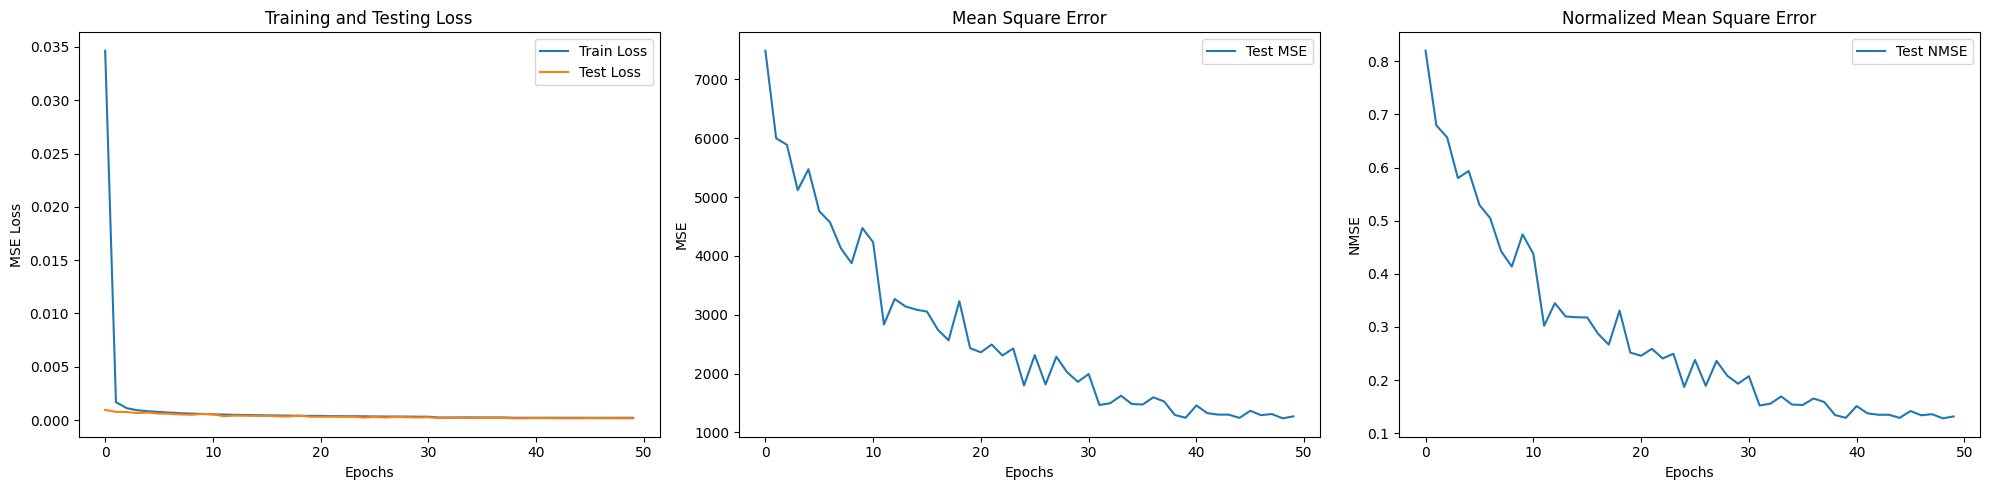

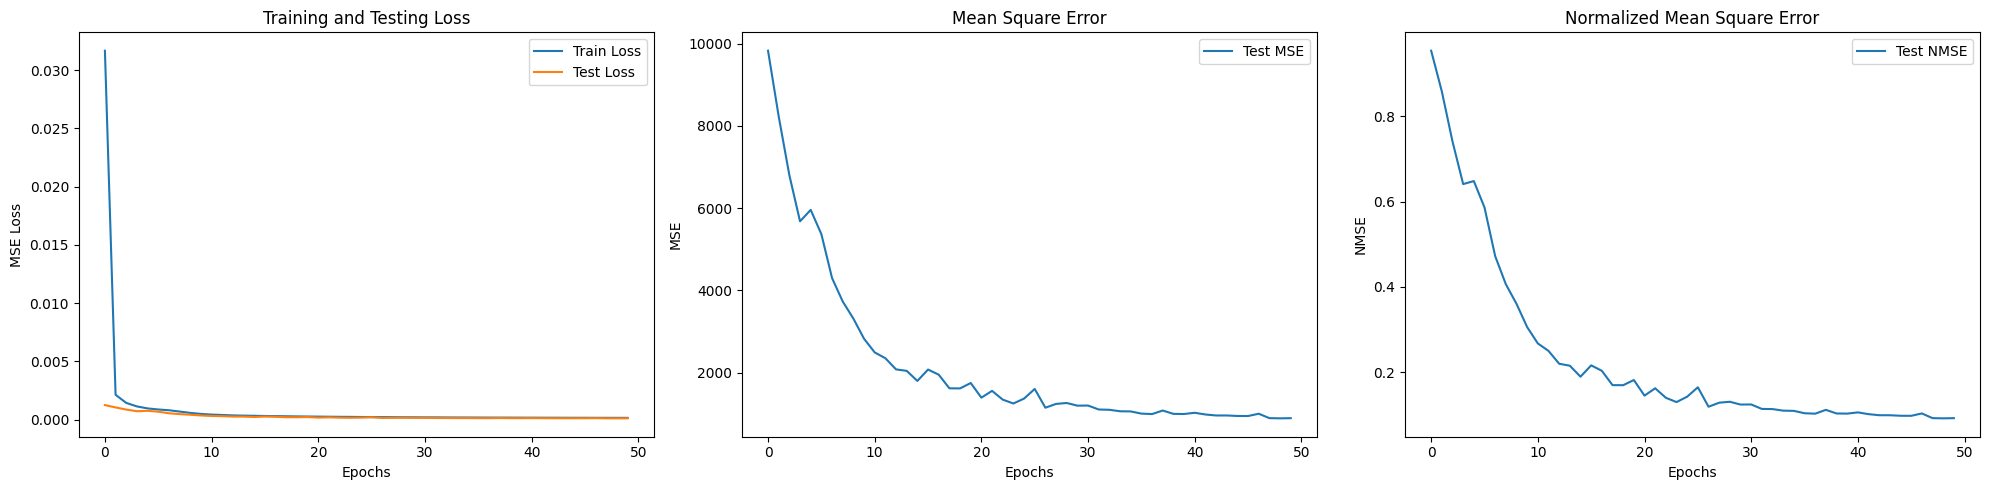

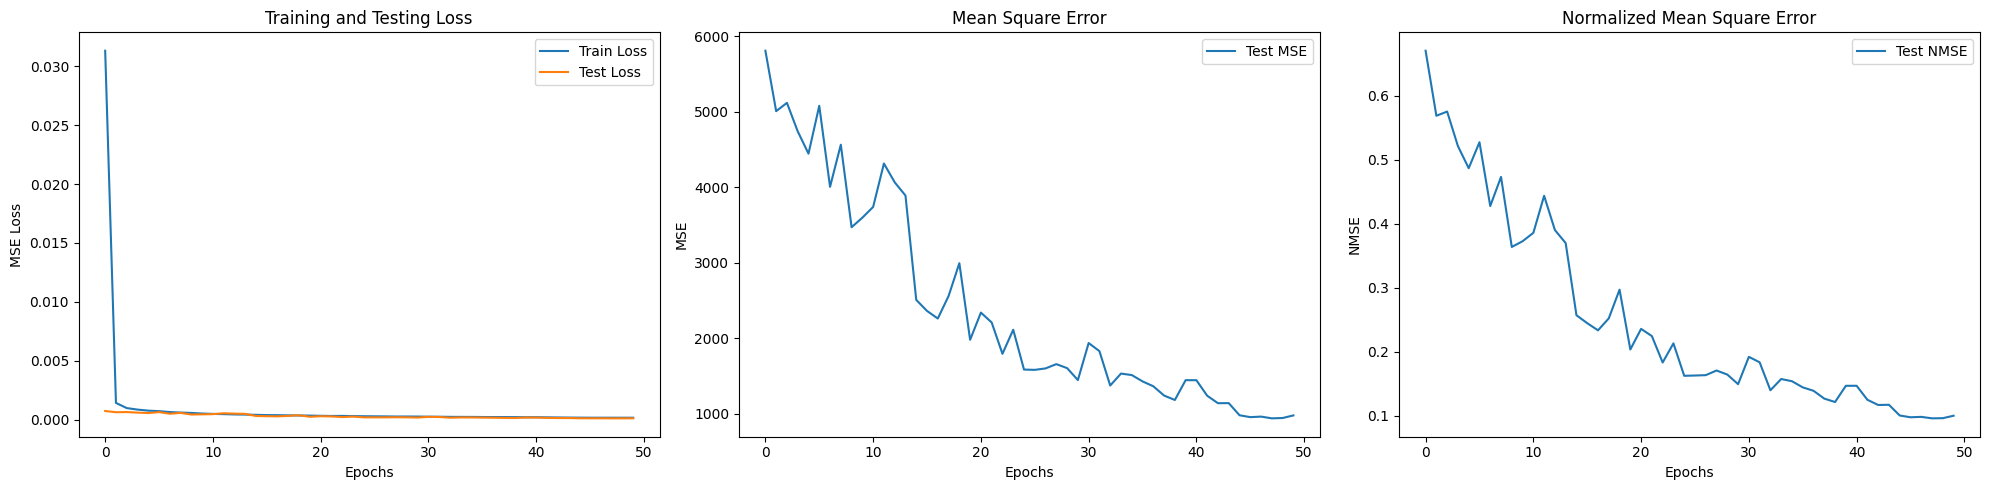

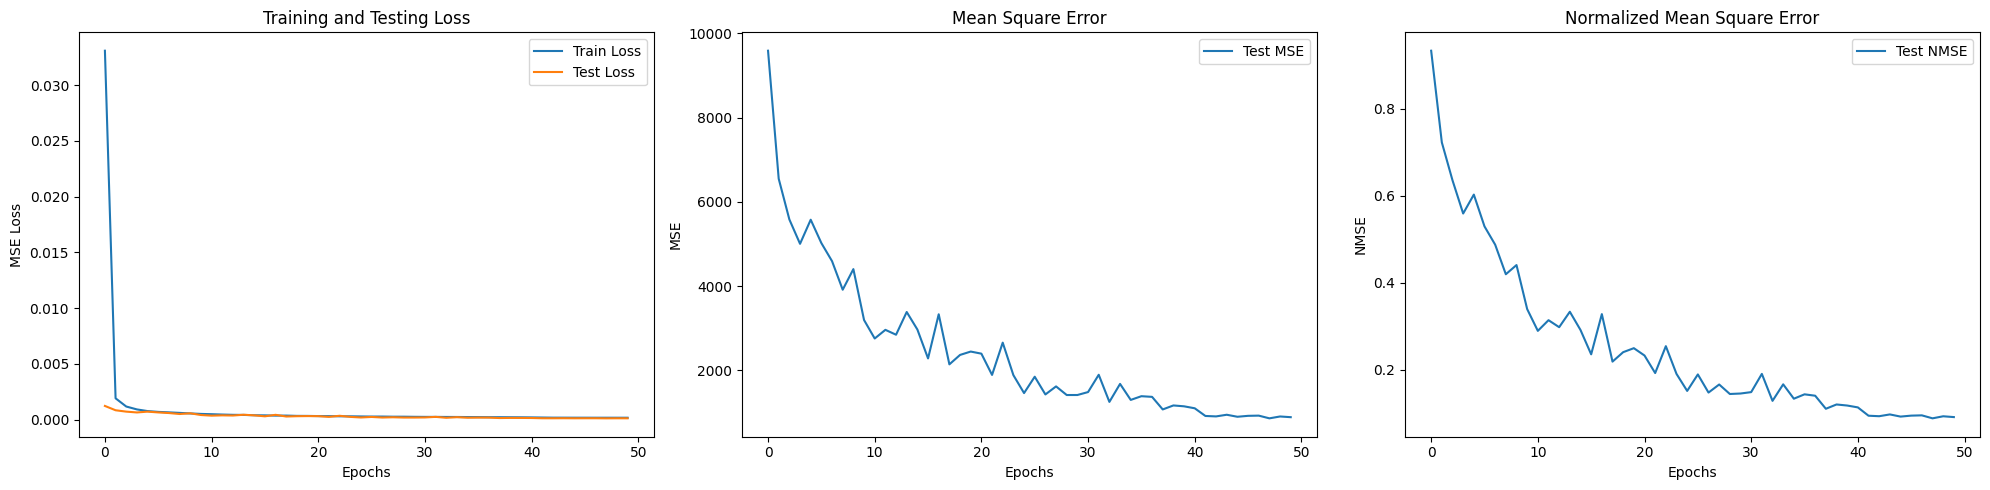

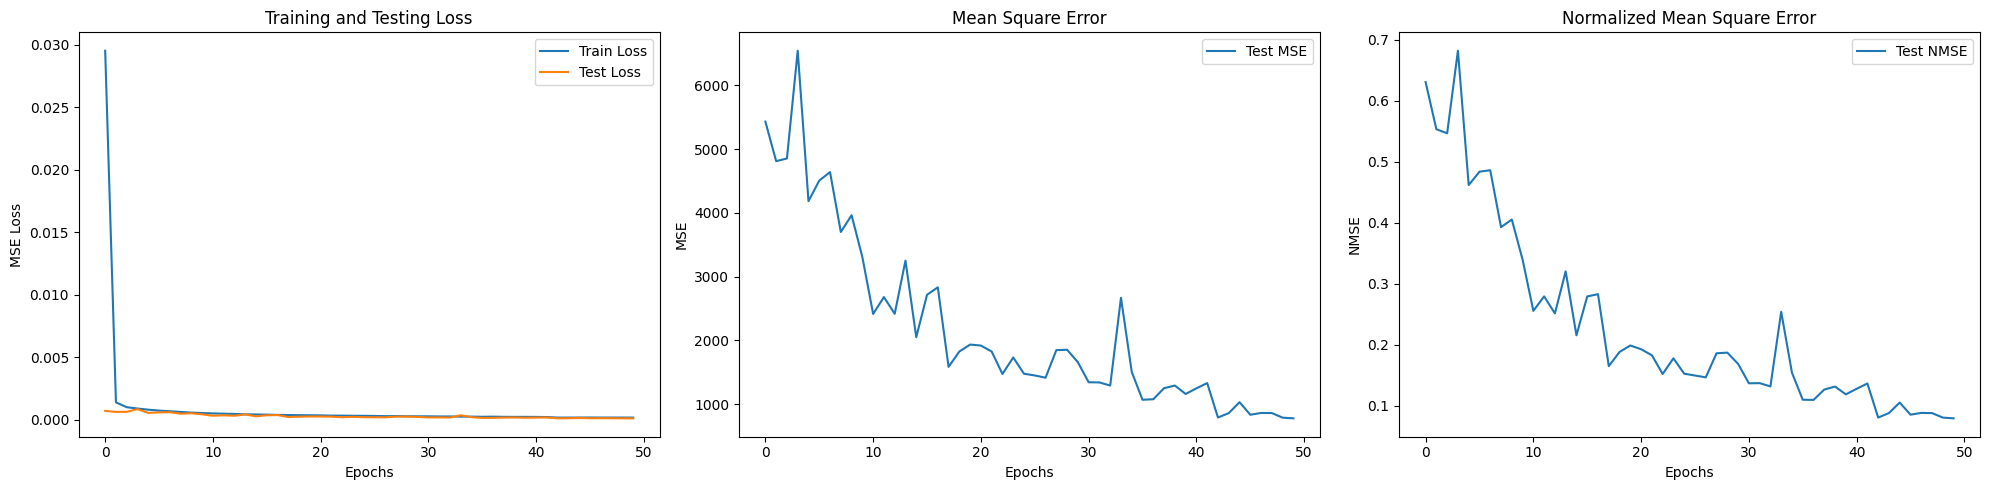

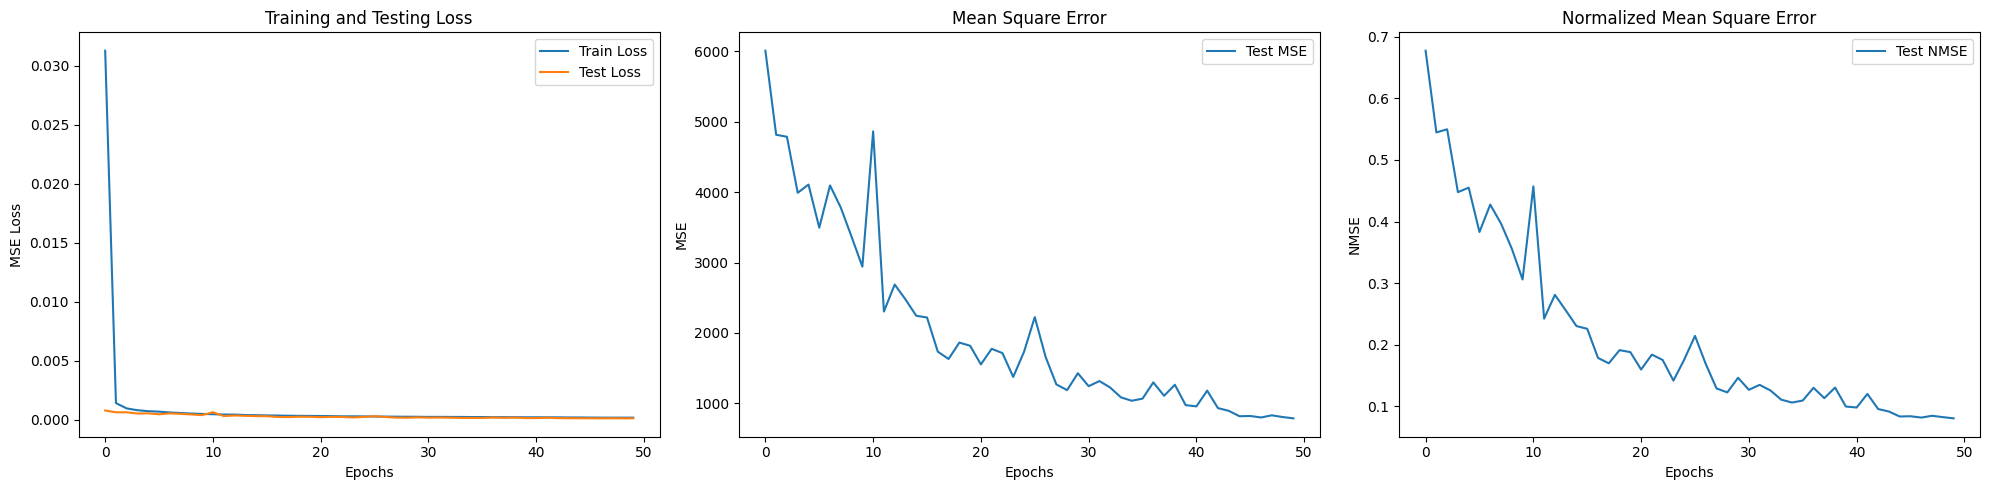

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open('A_dict.pkl', 'rb') as f:
    A_dict = pickle.load(f)

def generate_measurements(X, A):
    y = np.sign(A @ X.T).T
    return y

def create_data_loaders(y_data, x_data, batch_size=64):
    y_tensor = torch.from_numpy(y_data).float()
    x_tensor = torch.from_numpy(x_data).float()

    dataset = TensorDataset(y_tensor, x_tensor)

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return data_loader

class EnhancedOnebitCSMLP(nn.Module):
    def __init__(self, input_dim=500, output_dim=784, dropout_rate=0.0):
        super(EnhancedOnebitCSMLP, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        
        self.fc3 = nn.Linear(1024, 2048)
        self.bn3 = nn.BatchNorm1d(2048)
        
        # 第二阶段：收缩到输出维度
        self.fc4 = nn.Linear(2048, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        
        self.fc5 = nn.Linear(1024, 1024)
        self.bn5 = nn.BatchNorm1d(1024)
        
        # 输出层
        self.fc_out = nn.Linear(1024, output_dim)
        
        # Dropout正则化
        self.dropout = nn.Dropout(dropout_rate)
        
        # 初始化权重
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # 第一阶段
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, negative_slope=0.1)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, negative_slope=0.1)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, negative_slope=0.1)
        x = self.dropout(x)
        
        # 第二阶段
        x = self.fc4(x)
        x = self.bn4(x)
        x = F.leaky_relu(x, negative_slope=0.1)
        x = self.dropout(x)
        
        x = self.fc5(x)
        x = self.bn5(x)
        x = F.leaky_relu(x, negative_slope=0.1)
        
        # 输出层 - 不使用activation function以允许任意范围的输出值
        x = self.fc_out(x)
        
        return x

# 训练函数
def train_model(model, train_loader, test_loader, num_epochs=50, initial_lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)
    
    # 添加学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True,
        min_lr=1e-6
    )
    
    train_losses = []
    test_losses = []
    test_mses = []
    test_nmses = []
    learning_rates = []
    
    for epoch in range(num_epochs):
        # 记录当前学习率
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # 训练阶段
        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # 测试阶段
        model.eval()
        test_loss = 0
        all_outputs = []
        all_targets = []
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                
                all_outputs.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())
        
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        # 计算MSE和NMSE
        outputs_array = np.vstack(all_outputs)
        targets_array = np.vstack(all_targets)
        
        # 假设compute_metrics返回(mse, nmse)
        mse, nmse = compute_metrics(targets_array, outputs_array)
        test_mses.append(mse)
        test_nmses.append(nmse)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], LR: {current_lr:.6f}, Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}, MSE: {mse:.6f}, NMSE: {nmse:.6f}')
        
        # 更新学习率
        scheduler.step(avg_test_loss)
    
    # 绘制训练曲线
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Training and Testing Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(test_mses, label='Test MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('Mean Square Error')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(test_nmses, label='Test NMSE')
    plt.xlabel('Epochs')
    plt.ylabel('NMSE')
    plt.title('Normalized Mean Square Error')
    plt.legend()
    
    plt.tight_layout()
    # plt.show()
    
    return model, train_losses, test_losses, test_mses, test_nmses, learning_rates

# 可视化函数
def visualize_results(model, test_loader, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    all_inputs = []
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            all_inputs.append(inputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())
            
            if len(all_inputs) * inputs.shape[0] >= num_samples:
                break
    
    inputs_array = np.vstack(all_inputs)[:num_samples]
    targets_array = np.vstack(all_targets)[:num_samples]
    outputs_array = np.vstack(all_outputs)[:num_samples]
    
    # 为每个样本计算指标
    mse_values = []
    nmse_values = []
    for i in range(num_samples):
        mse, nmse = compute_metrics(targets_array[i], outputs_array[i])
        mse_values.append(mse)
        nmse_values.append(nmse)
    
    plt.figure(figsize=(15, 6))
    
    for i in range(num_samples):
        # 原始图像
        plt.subplot(2, num_samples, i+1)
        plt.imshow(targets_array[i].reshape(28, 28), cmap='gray')
        plt.title(f'Original {i+1}')
        plt.axis('off')
        
        # 重建图像
        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(outputs_array[i].reshape(28, 28), cmap='gray')
        plt.title(f'Recon {i+1}\nMSE: {mse_values[i]:.4f}\nNMSE: {nmse_values[i]:.4f}')
        plt.axis('off')
    
    # 计算平均指标
    avg_mse = np.mean(mse_values)
    avg_nmse = np.mean(nmse_values)
    
    # 打印平均指标
    print(f"Average MSE across all samples: {avg_mse:.6f}")
    print(f"Average NMSE across all samples: {avg_nmse:.6f}")
    
    plt.tight_layout()
    # plt.show()
    
    return avg_mse, avg_nmse  # 返回计算的平均指标

# 主训练循环
for input_dim in measurements:
    m_str = str(input_dim)
    
    # 使用已保存的矩阵
    if m_str in A_dict:
        A = A_dict[m_str]
        print(f"使用保存的矩阵: 维度 {input_dim}")
    else:
        print(f"矩阵维度 {input_dim} 不在已保存的数据中，跳过此维度")
        continue
    
    # 生成测量值
    y_train = generate_measurements(X_train_DL, A)
    y_test = generate_measurements(X_test_DL, A)
    
    # 创建训练和测试数据加载器
    train_loader = create_data_loaders(y_train, X_train, batch_size=100)
    test_loader = create_data_loaders(y_test, X_test, batch_size=100)
    print(f"Training model with input_dim = {input_dim}...")
    
    # 初始化模型
    model = EnhancedOnebitCSMLP(input_dim=input_dim, output_dim=784, dropout_rate=0.2)
    
    # 训练模型
    model, train_losses, test_losses, test_mses, test_nmses, lr_list = train_model(
        model, train_loader, test_loader, num_epochs=50
    )
    
    # 评估并可视化结果（可选）
    
    model_path = f"mlp_models/enhanced_onebit_cs_mlp_{input_dim}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")
    
    # 打印最终 NMSE
    final_nmse = test_nmses[-1]
    print(f"最终的 NMSE (input_dim={input_dim}): {final_nmse:.6f}\n")

Evaluating model with input_dim = 25...
使用保存的矩阵: 维度 25
NMSE for input_dim=25: 0.392864

Evaluating model with input_dim = 100...
使用保存的矩阵: 维度 100
NMSE for input_dim=100: 0.198423

Evaluating model with input_dim = 200...
使用保存的矩阵: 维度 200
NMSE for input_dim=200: 0.138751

Evaluating model with input_dim = 500...
使用保存的矩阵: 维度 500
NMSE for input_dim=500: 0.082641

Evaluating model with input_dim = 800...
使用保存的矩阵: 维度 800
NMSE for input_dim=800: 0.096381

Evaluating model with input_dim = 1000...
使用保存的矩阵: 维度 1000
NMSE for input_dim=1000: 0.091452

Evaluating model with input_dim = 1500...
使用保存的矩阵: 维度 1500
NMSE for input_dim=1500: 0.086487

Evaluating model with input_dim = 2000...
使用保存的矩阵: 维度 2000
NMSE for input_dim=2000: 0.073874



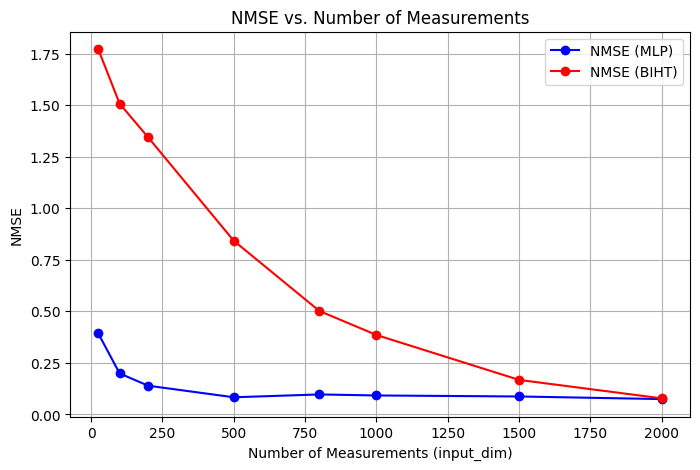

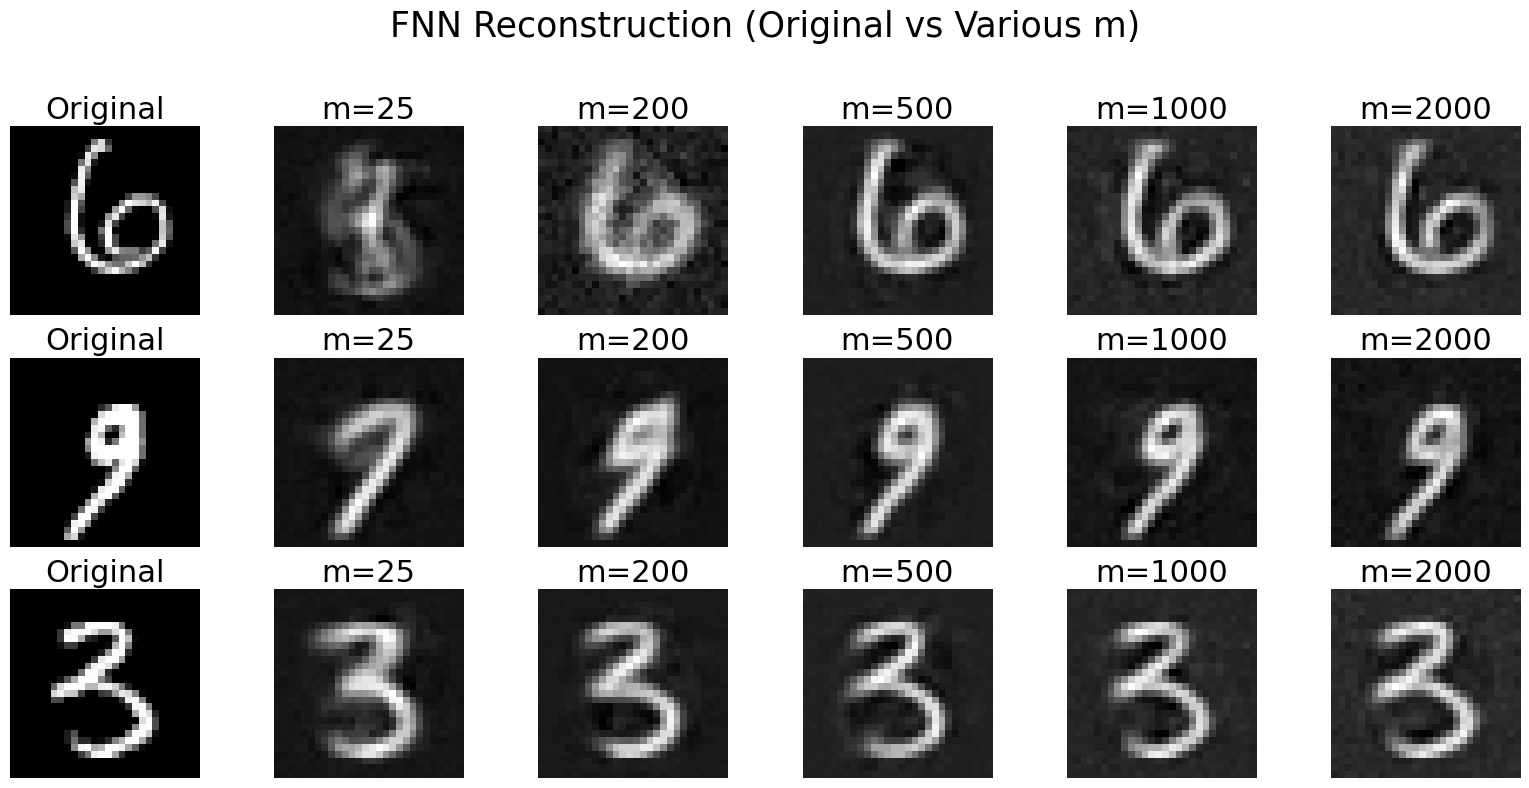

In [63]:
nmse_values_mlp = []

# 加载保存的A矩阵
with open('A_dict.pkl', 'rb') as f:
    A_dict = pickle.load(f)

for input_dim in measurements:
    m_str = str(input_dim)
    print(f"Evaluating model with input_dim = {input_dim}...")
    
    # 使用已保存的矩阵
    if m_str in A_dict:
        A = A_dict[m_str]
        print(f"使用保存的矩阵: 维度 {input_dim}")
    else:
        print(f"矩阵维度 {input_dim} 不在已保存的数据中，跳过此维度")
        continue
    
    # 生成测量数据
    y_train = generate_measurements(X_train, A)
    y_test = generate_measurements(X_test, A)
    
    # 创建数据加载器
    train_loader = create_data_loaders(y_train, X_train, batch_size=100)
    test_loader = create_data_loaders(y_test, X_test, batch_size=100)
    
    # 初始化模型
    model = EnhancedOnebitCSMLP(input_dim=input_dim, output_dim=784, dropout_rate=0.2)
    
    # 加载训练好的模型
    model_path = f"mlp_models/enhanced_onebit_cs_mlp_{input_dim}.pth"
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  # 进入评估模式
    
    # 获取测试数据的前100个样本
    test_iter = iter(test_loader)
    inputs, targets = next(test_iter)
    inputs, targets = inputs[:100].to(device), targets[:100].to(device)  # 仅取前 100 个样本

    # 前向传播
    with torch.no_grad():
        outputs = model(inputs)

    # 使用compute_metrics计算MSE和NMSE
    targets_np = targets.cpu().numpy()
    outputs_np = outputs.cpu().numpy()
    
    # 假设compute_metrics返回(mse, nmse)元组
    mse, nmse = compute_metrics(targets_np, outputs_np)
    nmse_values_mlp.append(nmse)

    print(f"NMSE for input_dim={input_dim}: {nmse:.6f}\n")

# 绘制 NMSE 随着 measurements 的变化
    
plt.figure(figsize=(8, 5))
plt.plot(measurements, nmse_values_mlp, marker='o', linestyle='-', color='b', label="NMSE (MLP)")
plt.plot(measurements, mean_nmse_biht, marker='o', linestyle='-', color='r', label="NMSE (BIHT)")
plt.xlabel("Number of Measurements (input_dim)")
plt.ylabel("NMSE")
plt.title("NMSE vs. Number of Measurements")
plt.grid(True)
plt.legend()
plt.show()


# -------- Compare -----------

measurements_fnn_show = [25, 200, 500, 1000, 2000]
sample_indices = [100, 1000, 5000]

# 加载 A 矩阵
with open('A_dict.pkl', 'rb') as f:
    A_dict = pickle.load(f)

# 存储重建结果
all_outputs = []
all_targets = []

for sample_idx in sample_indices:
    recon_images = []
    target_image = None

    for m in measurements_fnn_show:
        A = A_dict[str(m)]
        x = X_test[sample_idx]
        y = np.sign(A @ x)

        input_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0).to(device)

        model = EnhancedOnebitCSMLP(input_dim=m, output_dim=784, dropout_rate=0.2)
        model_path = f"mlp_models/enhanced_onebit_cs_mlp_{m}.pth"
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()

        with torch.no_grad():
            output = model(input_tensor).cpu().numpy().squeeze()
            recon_images.append(output.reshape(28, 28))

        if target_image is None:
            target_image = x.reshape(28, 28)

    all_outputs.append(recon_images)
    all_targets.append(target_image)

fig, axes = plt.subplots(len(sample_indices), len(measurements_fnn_show) + 1, figsize=(16, 8))

for row in range(len(sample_indices)):
    # 原图
    axes[row, 0].imshow(all_targets[row], cmap='gray')
    axes[row, 0].set_title("Original", fontsize=22)
    axes[row, 0].axis('off')

    for col in range(len(measurements_fnn_show)):
        axes[row, col + 1].imshow(all_outputs[row][col], cmap='gray')
        axes[row, col + 1].set_title(f"m={measurements_fnn_show[col]}", fontsize=22)
        axes[row, col + 1].axis('off')

plt.suptitle("FNN Reconstruction (Original vs Various m)", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 2.3 VAEs

The structure of the Generative Model

In [31]:

# class Encoder(nn.Module):
#     def __init__(self, latent_dim=64):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(784, 512)
#         self.fc2 = nn.Linear(512, 256)
#         self.fc_mu = nn.Linear(256, latent_dim)
#         self.fc_logvar = nn.Linear(256, latent_dim)

#     def forward(self, x):
#         x = x.view(-1, 784)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         mu = self.fc_mu(x)
#         logvar = self.fc_logvar(x)
#         return mu, logvar


# class Decoder(nn.Module):
#     def __init__(self, latent_dim=64):
#         super(Decoder, self).__init__()
#         self.fc1 = nn.Linear(latent_dim, 256)
#         self.fc2 = nn.Linear(256, 512)
#         self.fc3 = nn.Linear(512, 784)

#     def forward(self, z):
#         z = F.relu(self.fc1(z))
#         z = F.relu(self.fc2(z))
#         x = torch.sigmoid(self.fc3(z))
#         return x

# def reparameterize(mu, logvar):
#     std = torch.exp(0.5 * logvar)
#     eps = torch.randn_like(std)
#     return mu + eps * std

# class VAE(nn.Module):
#     def __init__(self, latent_dim=40):
#         super(VAE, self).__init__()
#         self.encoder = Encoder(latent_dim)
#         self.decoder = Decoder(latent_dim)

#     def forward(self, x):
#         mu, logvar = self.encoder(x)
#         z = reparameterize(mu, logvar)
#         x_recon = self.decoder(z)
#         return x_recon, mu, logvar

# def vae_loss(x_recon, x, mu, logvar):
#     x = torch.clamp(x, 0, 1)
#     recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / x.size(0)
#     kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
#     return recon_loss + kl_div

# Encoder: 784 → 512 → 256 → (mu, logvar)
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim1=512, hidden_dim2=256, latent_dim=20):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mu = nn.Linear(hidden_dim2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = self.relu(self.fc1(x))
        h = self.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Decoder: latent_dim → 256 → 512 → 784
class Decoder(nn.Module):
    def __init__(self, latent_dim=20, hidden_dim1=256, hidden_dim2=512, output_dim=784):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        h = self.relu(self.fc1(z))
        h = self.relu(self.fc2(h))
        x_recon = self.sigmoid(self.fc3(h))
        x_recon = x_recon.view(-1, 1, 28, 28)
        return x_recon

# Full VAE
class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim=input_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, output_dim=input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

# 定义 VAE 的损失函数：重构误差 + KL 散度
def loss_function(x_recon, x, mu, logvar):
    # 二值交叉熵重构损失
    BCE = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    # KL 散度损失
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


# 训练函数
def train(epoch, model, optimizer, train_loader, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} Batch {batch_idx} Loss: {loss.item()/len(data):.4f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# 测试函数
def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            test_loss += loss_function(recon, data, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')

def compare_images(model, device, test_loader, num_images=8):
    model.eval()
    with torch.no_grad():
        # 从测试集中取出一批数据
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon, _, _ = model(data)

    # 将数据转换为 CPU 上的 numpy 数组
    data = data.cpu().numpy()
    recon = recon.cpu().numpy()

    # 绘制对比图
    plt.figure(figsize=(num_images * 2, 4))
    for i in range(num_images):
        # 原始图片
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(data[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Original")

        # 重构图片
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title("Reconstructed")

    plt.tight_layout()
    plt.show()

batch_size = 128
epochs = 50
latent_dim = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
# 数据预处理与加载
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# print(train_dataset.train_data.shape)
# print(test_dataset.test_data.shape)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 模型与优化器
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    train(epoch, model, optimizer, train_loader, device)
    test(model, test_loader, device)
    # compare_images(model, device, test_loader, num_images=8)

Epoch 1 Batch 0 Loss: 544.2190
Epoch 1 Batch 100 Loss: 203.7044
Epoch 1 Batch 200 Loss: 180.1976
Epoch 1 Batch 300 Loss: 157.4985
Epoch 1 Batch 400 Loss: 145.8243
====> Epoch: 1 Average loss: 176.6208
====> Test set loss: 139.2472
Epoch 2 Batch 0 Loss: 139.0632
Epoch 2 Batch 100 Loss: 139.9041
Epoch 2 Batch 200 Loss: 129.5375
Epoch 2 Batch 300 Loss: 128.0243
Epoch 2 Batch 400 Loss: 123.4924
====> Epoch: 2 Average loss: 129.4872
====> Test set loss: 120.5955
Epoch 3 Batch 0 Loss: 118.8860
Epoch 3 Batch 100 Loss: 119.2458
Epoch 3 Batch 200 Loss: 117.6041
Epoch 3 Batch 300 Loss: 122.3185
Epoch 3 Batch 400 Loss: 112.1190
====> Epoch: 3 Average loss: 117.7882
====> Test set loss: 113.7401
Epoch 4 Batch 0 Loss: 114.7934
Epoch 4 Batch 100 Loss: 112.3307
Epoch 4 Batch 200 Loss: 113.8932
Epoch 4 Batch 300 Loss: 111.7011
Epoch 4 Batch 400 Loss: 113.0100
====> Epoch: 4 Average loss: 112.9722
====> Test set loss: 110.6492
Epoch 5 Batch 0 Loss: 115.1116
Epoch 5 Batch 100 Loss: 110.6884
Epoch 5 Batc

Step 0, Loss: 55.367233, norm: 127.57610321044922, corr: 26.543224334716797
Step 1000, Loss: 15.645052, norm: 60.08114242553711, corr: 25.57216453552246
Step 2000, Loss: 3.907835, norm: 33.48227310180664, corr: 20.28053855895996
Step 3000, Loss: -0.627297, norm: 19.216670989990234, corr: 15.236915588378906
Step 4000, Loss: -2.171615, norm: 13.308341026306152, corr: 12.729434967041016
Step 5000, Loss: -4.173228, norm: 10.494446754455566, corr: 13.122068405151367
Step 6000, Loss: -5.285769, norm: 10.21286392211914, corr: 14.30468463897705
Step 7000, Loss: -5.914390, norm: 10.007286071777344, corr: 14.937952995300293
Step 8000, Loss: -6.111609, norm: 10.485981941223145, corr: 15.545103073120117
Step 9000, Loss: -6.304860, norm: 10.74090576171875, corr: 15.979007720947266


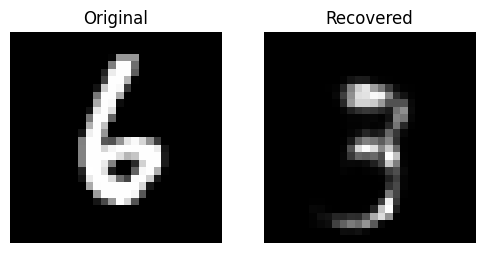

In [60]:
vae = model
vae.decoder.eval()

with open("A_dict.pkl", "rb") as f:
    A_dict = pickle.load(f)

# 假设你选 m=100 的观测矩阵
A = A_dict['25']  # shape: [100, 784]
A = torch.tensor(A, dtype=torch.float32).to(device)
idx = torch.randint(0, len(X_test_tensor), (1,))
x_star = X_test_tensor[idx].to(device)  # shape: [1, 784]

# 获取 one-bit measurement
y = torch.sign(A @ x_star.T).squeeze()  # shape: [100]
# print(y.shape)
#y = y.view(-1,784)
z = torch.randn(1, latent_dim, requires_grad=True, device=device)  # 可优化变量

optimizer = optim.Adam([z], lr=1e-3)
m = A.shape[0]
sqrt_2pi_over_m = torch.sqrt(torch.tensor(2 * torch.pi)) / m

sqrt_2_pi = np.sqrt(2 / np.pi)

for step in range(10000):
    optimizer.zero_grad()

    x_hat = vae.decoder(z)  # [1, 784]
    x_hat = x_hat.view(-1,784)
    x_hat = x_hat.squeeze()

    y_hat = (A @ x_hat.T).squeeze()  # shape: [m]

    # loss = F.mse_loss(y_hat, y)  # y 是 ±1
    norm_term = torch.norm(x_hat)**2
    corr_term = (y @ (A @ x_hat))
    loss = 0.6* norm_term - sqrt_2_pi * corr_term
    # loss = F.mse_loss(y_hat, y)

    loss.backward()
    optimizer.step()

    if step % 1000 == 0:
        print(f"Step {step}, Loss: {loss.item():.6f}, norm: {norm_term}, corr: {corr_term}")



x_hat_img = x_hat.view(28, 28).detach().cpu().numpy()
x_star_img = x_star.view(28, 28).cpu().numpy()

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(x_star_img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_hat_img, cmap='gray')
plt.title("Recovered")
plt.axis('off')

plt.show()

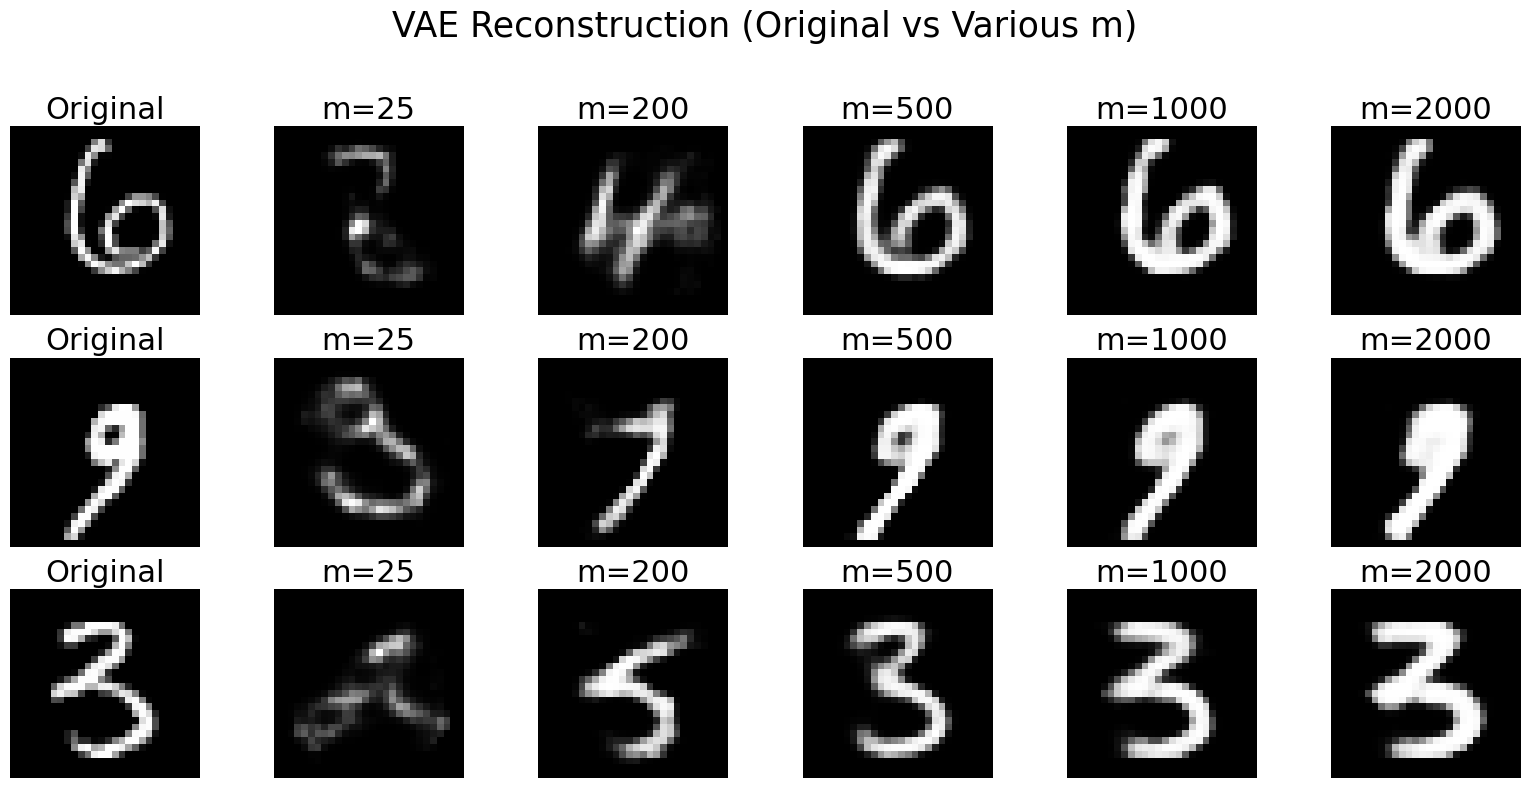

In [65]:
vae.decoder.eval()

sample_indices = [100, 1000, 5000]
measurements_vae_show = [25, 200, 500, 1000, 2000]
latent_dim = vae.decoder.fc1.in_features  # 自动获取 latent_dim

# 加载测量矩阵
with open("A_dict.pkl", "rb") as f:
    A_dict = pickle.load(f)

recon_results = []
originals = []

for idx in sample_indices:
    x_star = X_test_tensor[idx].to(device)
    x_star_img = x_star.view(28, 28).cpu().numpy()
    originals.append(x_star_img)

    row_results = []
    for m in measurements_vae_show:
        A = torch.tensor(A_dict[str(m)], dtype=torch.float32).to(device)
        y = torch.sign(A @ x_star.T).squeeze()  # shape: [m]

        z = torch.randn(1, latent_dim, requires_grad=True, device=device)
        optimizer = optim.Adam([z], lr=1e-3)
        sqrt_2_pi = np.sqrt(2 / np.pi)

        for step in range(5000):  # 迭代次数可以根据效果调整
            optimizer.zero_grad()

            x_hat = vae.decoder(z).view(-1, 784).squeeze()
            norm_term = torch.norm(x_hat)**2
            corr_term = (y @ (A @ x_hat))
            loss = 0.6 * norm_term - sqrt_2_pi * corr_term

            loss.backward()
            optimizer.step()

        x_hat_img = x_hat.view(28, 28).detach().cpu().numpy()
        row_results.append(x_hat_img)

    recon_results.append(row_results)

# ------------------- 🎨 可视化 -------------------
fig, axes = plt.subplots(len(sample_indices), len(measurements_vae_show) + 1, figsize=(16, 8))

for row in range(len(sample_indices)):
    axes[row, 0].imshow(originals[row], cmap='gray')
    axes[row, 0].set_title("Original", fontsize=22)
    axes[row, 0].axis('off')

    for col in range(len(measurements_vae_show)):
        axes[row, col + 1].imshow(recon_results[row][col], cmap='gray')
        axes[row, col + 1].set_title(f"m={measurements_vae_show[col]}", fontsize=22)
        axes[row, col + 1].axis('off')

plt.suptitle("VAE Reconstruction (Original vs Various m)", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

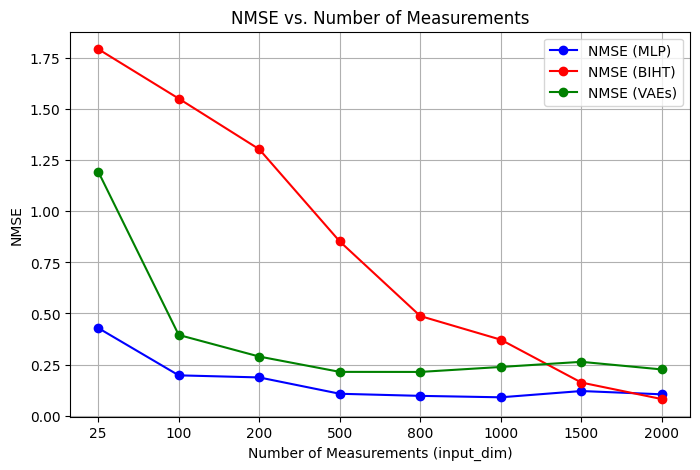

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(measurements, nmse_values, marker='o', linestyle='-', color='b', label="NMSE (MLP)")
plt.plot(measurements, mean_nmse_biht, marker='o', linestyle='-', color='r', label="NMSE (BIHT)")
plt.plot(measurements, nmse_list_vae, marker='o', linestyle='-', color='g', label="NMSE (VAEs)")
plt.xlabel("Number of Measurements (input_dim)")
plt.ylabel("NMSE")
plt.title("NMSE vs. Number of Measurements")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 载入训练好的VAE模型
vae = model
vae.decoder.eval()

with open("A_dict.pkl", "rb") as f:
    A_dict = pickle.load(f)

# 假设你选 m=100 的观测矩阵
A = A_dict['500']  # shape: [100, 784]
A = torch.tensor(A, dtype=torch.float32).to(device)
idx = torch.randint(0, len(X_test_tensor), (1,))
x_star = X_test_tensor[idx].to(device)  # shape: [1, 784]

# 获取 one-bit measurement
y = torch.sign(A @ x_star.T).squeeze()  # shape: [100]
y1 = y.clone()  # 使用 copy() 创建副本
y2 = y.clone()
latent_dim = 30
z = torch.randn(1, latent_dim, requires_grad=True, device=device)  # 可优化变量
print(z)
#z1 = torch.randn(1, latent_dim, requires_grad=True, device=device)

z1 = torch.tensor(z.clone().cpu().detach().numpy(), requires_grad=True, device=device)
z2 = torch.tensor(z.clone().cpu().detach().numpy(), requires_grad=True, device=device)
print(z1)
print(z2)

# 为每个损失定义不同的优化器
optimizer_loss1 = optim.Adam([z1], lr=1e-4)  # 用于第一个损失
optimizer_loss2 = optim.Adam([z2], lr=1e-4)  # 用于第二个损失

m = A.shape[0]
sqrt_2pi_over_m = torch.sqrt(torch.tensor(2 * torch.pi)) / m

sqrt_2_pi = np.sqrt(2 / np.pi)

# 两种损失独立优化
for step in range(50000):
    optimizer_loss1.zero_grad()

    x_hat1 = vae.decoder(z1)  # [1, 784]
    x_hat1 = x_hat1.view(-1, 784)
    x_hat1 = x_hat1.squeeze()

    y_hat1 = (A @ x_hat1.T).squeeze()  # shape: [m]

    # loss = F.mse_loss(y_hat, y)  # y 是 ±1
    norm_term1 = torch.norm(x_hat1)**2
    corr_term1 = (y1 @ (A @ x_hat1))
    loss1 = 0.6 * norm_term1 - sqrt_2_pi * corr_term1

    loss1.backward()
    optimizer_loss1.step()
    if step % 1000 == 0:
        print(f"Step {step}, Loss1: {loss1.item():.6f}, norm: {norm_term1}, corr: {corr_term1}")

# 第二轮优化，针对 loss2
for step in range(50000):
    optimizer_loss2.zero_grad()

    x_hat2 = vae.decoder(z2)  # [1, 784]
    x_hat2 = x_hat2.view(-1, 784)
    x_hat2 = x_hat2.squeeze()

    y_hat2 = (A @ x_hat2.T).squeeze()  # shape: [m]

    norm_term2 = torch.norm(x_hat2)**2
    corr_term2 = (y2 @ (A @ x_hat2))
    loss2 = norm_term2 - sqrt_2_pi * corr_term2

    loss2.backward()
    optimizer_loss2.step()

    if step % 1000 == 0:
        print(f"Step {step}, Loss2: {loss2.item():.6f}, norm: {norm_term2}, corr: {corr_term2}")

# 显示两个不同损失对应的重建图像
# loss1对应的图像
x_hat_img1 = x_hat1.view(28, 28).detach().cpu().numpy()
x_star_img1 = x_star.view(28, 28).cpu().numpy()

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(x_star_img1, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_hat_img1, cmap='gray')
plt.title("Recovered (Loss1)")
plt.axis('off')

plt.show()

# loss2对应的图像
x_hat_img2 = x_hat2.view(28, 28).detach().cpu().numpy()
x_star_img2 = x_star.view(28, 28).cpu().numpy()

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(x_star_img2, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_hat_img2, cmap='gray')
plt.title("Recovered (Loss2)")
plt.axis('off')

plt.show()